### Imports

In [19]:
%load_ext autoreload
%autoreload 2
import sys
import platform
from pathlib import Path
from os import environ
if platform.system() == "Darwin": # Nat laptop
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/sleep_deprivation/DataPaths/'])
    plot_dir = Path("/Users/nkinsky/Documents/UM/Working/Bapun_Data/plots")
else:
    if environ["HOSTNAME"] == "lnx00004": # Nat Linux computer
        sys.path.extend(['/data/GitHub/NeuroPy'])
        sys.path.extend(['/data/GitHub/sleep_loss_hippocampal_replay/analysis_and_figure_code/DataPaths'])
        plot_dir = Path('/data/Clustering/plots')
    else:  #BG computer
        sys.path.extend(['/home/nkinsky/Documents/GitHub/NeuroPy'])
        sys.path.extend(['/home/nkinsky/Documents/GitHubPrivate/pythonprogs/DataPaths/'])

group_data_dir = Path('/data/Clustering/grpdata')
    
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import pingouin as pg
import scipy.signal as sg
import matplotlib.pyplot as plt
from neuropy.utils.mathutil import min_max_scaler
from scipy.ndimage import gaussian_filter1d, gaussian_filter

from neuropy import plotting
from neuropy.analyses.placefields import Pf1D
from neuropy.core.position import Position
from neuropy.plotting.ratemaps import plot_ratemap
from neuropy.plotting.figure import Fig
from neuropy.utils.misc import flatten

import subjects
from remaze_stats_utils import bootstrap_resample

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define useful functions

In [2]:
def pf_corr_maze_remaze(row, nbins_each_sesh=50):
    """Calculate PF correlation for each row/neuron. 
    
    row: a DataFrame row of values (or 1d ndarray) where the first nbins_each_sesh bins 
    are firing rates for MAZE in each bin and the next nbins_each_sesh are for reMAZE"""
    maze_tc = row.values[0:nbins_each_sesh]
    remaze_tc = row.values[nbins_each_sesh:]
    

    return np.corrcoef([maze_tc, remaze_tc])[0, 1]

In [3]:
def get_pf_loc(row, nbins_each_sesh=50, end_prop=0.125):
    """Calculate placefield peak location
    
    row: a DataFrame row of values (or 1d ndarray) where the first nbins_each_sesh bins 
    are firing rates for MAZE in each bin and the next nbins_each_sesh are for reMAZE
    
    end_prop: propotion of the track corresponding to end - fields with locations less than end_prop or 
    more than 1 - end_prop are classified as 'end' pfs while the rest are classified as 'middle' pfs"""

    # Get location on track
    maze_tc = row.values[0:nbins_each_sesh]
    imax = np.argmax(maze_tc)
    
    if (imax < (nbins_each_sesh * end_prop)) | (imax > (nbins_each_sesh - nbins_each_sesh * end_prop)):
        loc = "end"
    else:
        loc = "middle"

    return loc

In [4]:
def pf_corr_maze_remaze_ends(row, nbins_each_sesh=50, end_prop=0.125):
    """Calculate PF correlation for each row/neuron but only consider neurons with peaks in at the end of the tracks,
    within `end_prop` of the end of the track"""

    # Calculate correlations
    pf_corr_row = pf_corr_maze_remaze(row, nbins_each_sesh=nbins_each_sesh)

    # Get location on track
    maze_tc = row.values[0:nbins_each_sesh]
    imax = np.argmax(maze_tc)

    if (imax < (nbins_each_sesh * end_prop)) | (imax > (nbins_each_sesh - nbins_each_sesh * end_prop)):
        return pf_corr_row
    else:
        return np.nan


In [5]:
def pf_corr_maze_remaze_middle(row, nbins_each_sesh=50, end_prop=0.125):
    """Calculate PF correlation for each row/neuron but only consider neurons with peaks in at the end of the tracks,
    within `end_prop` of the end of the track"""

    # Calculate correlations
    pf_corr_row = pf_corr_maze_remaze(row, nbins_each_sesh=nbins_each_sesh)

    # Get location on track
    maze_tc = row.values[0:nbins_each_sesh]
    imax = np.argmax(maze_tc)

    if (imax > (nbins_each_sesh * end_prop)) & (imax < (nbins_each_sesh - nbins_each_sesh * end_prop)):
        return pf_corr_row
    else:
        return np.nan


In [6]:
def get_imax(row):
    maze_tc = row.values[0:nbins_each_sesh]
    imax = np.argmax(maze_tc)

    return imax

In [7]:
def delta_rate_index(row, nbins_each_sesh=50, use_same_peak_bin=False):
    """Calculate change in max firing rate from MAZE to REMAZE for each row/neuron"""
    maze_tc = row.values[0:nbins_each_sesh]
    remaze_tc = row.values[nbins_each_sesh:]
    
    maze_max = np.nanmax(maze_tc)
    remaze_max = np.nanmax(remaze_tc)
    if use_same_peak_bin:
        imax = np.argmax(maze_tc)
        remaze_max = remaze_tc[imax]
    
    return (maze_max - remaze_max) / (maze_max + remaze_max)

In [8]:
def delta_pf_peak(row, nbins_each_sesh=50):
    maze_tc = row.values[0:nbins_each_sesh]
    remaze_tc = row.values[nbins_each_sesh:]

    return np.argmax(maze_tc) - np.argmax(remaze_tc)

In [9]:
def get_number_of_fields(pf_peak_or_width_list):
    nfields = [cell_peaks.size if ~np.all(np.isnan(cell_peaks)) else 0 for cell_peaks in pf_peak_or_width_list]

    return nfields

### Load in sessions

In [10]:
#1st # = maze trials, 2nd # = remaze trial, 2 trials = 1 lap up/down
ntrials_dict = {"RatUDay2": [25, 17], "RatVDay1": [23, 30], "RatVDay3": [163, 103],
                "RatSDay3": [23, 16], "RatUDay1": [54, 4], "RatUDay4": [32, 4],
                "RatVDay2": [79, 92], "RatRDay2": [41, 10]}
sessions = subjects.remaze_sess()

### Examine firing rates of interneurons in each session

In [11]:
def calc_rough_uniformity_metric(pf_in):
    metric = []
    for ratemap_spiketrains_pos in pf_in.ratemap_spiketrains_pos:
        res = sstats.ecdf(ratemap_spiketrains_pos/pf_in.coords.max())
        metric.append(np.abs(res.cdf.probabilities - res.cdf.quantiles).sum())

    return np.array(metric)
    
# calc_rough_uniformity_metric(pfmaze)

In [12]:
# Calculate mean firing rates
neuron_type = "stable" # "stable" # 'all' or 'stable'
fr_df = []
for ids, sess in enumerate(sessions):
    assert neuron_type in ("all", "stable")
    neurons_use = sess.neurons if neuron_type == "all" else sess.neurons_stable
    maze = sess.paradigm["maze"].flatten()
    remaze = sess.paradigm["re-maze"].flatten()

    fr_df_maze = neurons_use.time_slice(*maze).to_dataframe()
    fr_df_maze["session_type"] = "MAZE"
    
    fr_df_remaze = neurons_use.time_slice(*remaze).to_dataframe()
    fr_df_remaze["session_type"] = "reMAZE"

    delta_fr = fr_df_maze["mean_frate"] - fr_df_remaze["mean_frate"]
    fr_df_maze["delta_frate_maze_remaze"] = delta_fr
    fr_df_remaze["delta_frate_maze_remaze"] = np.nan
    
    fr_df_temp = pd.concat((fr_df_maze, fr_df_remaze), axis=0)
    fr_df_temp['neuron_id'] = fr_df_temp.index
    
    fr_df_temp["grp"] = sess.tag
    fr_df_temp["session"] = ids

    fr_df.append(fr_df_temp)
    
fr_df = pd.concat(fr_df, axis=0, ignore_index=True)
fr_df["nid_unique"] = fr_df.apply(lambda row: f"{row.session}_{row.neuron_id}", axis=1)
fr_df

Number of neurons: 123
Number of neurons: 123
Number of neurons: 249
Number of neurons: 249
Number of neurons: 99
Number of neurons: 99
Number of neurons: 95
Number of neurons: 95
Number of neurons: 95
Number of neurons: 95
Number of neurons: 66
Number of neurons: 66
Number of neurons: 185
Number of neurons: 185
Number of neurons: 62
Number of neurons: 62
Number of neurons: 49
Number of neurons: 49


,neuron_type,neuron_id,nspikes,mean_frate,session_type,delta_frate_maze_remaze,grp,session,nid_unique
0,pyr,0,777,0.211659,MAZE,0.125499,NSD,0,0_0
1,pyr,1,1994,0.543176,MAZE,-0.005908,NSD,0,0_1
2,mua,2,11173,3.043585,MAZE,0.579460,NSD,0,0_2
3,pyr,3,180,0.049033,MAZE,-0.058142,NSD,0,0_3
4,pyr,4,740,0.201580,MAZE,0.084198,NSD,0,0_4
...,...,...,...,...,...,...,...,...,...
2041,pyr,44,6841,1.760422,reMAZE,NaN,SD,8,8_44
2042,pyr,45,369,0.094956,reMAZE,NaN,SD,8,8_45
2043,pyr,46,6436,1.656202,reMAZE,NaN,SD,8,8_46
2044,pyr,47,98,0.025219,reMAZE,NaN,SD,8,8_47


### Bootstrap resample mean firing rates

In [26]:
fr_df[fr_df.neuron_type == "pyr"]

,neuron_type,neuron_id,nspikes,mean_frate,session_type,delta_frate_maze_remaze,grp,session,nid_unique
0,pyr,0,777,0.211659,MAZE,0.125499,NSD,0,0_0
1,pyr,1,1994,0.543176,MAZE,-0.005908,NSD,0,0_1
3,pyr,3,180,0.049033,MAZE,-0.058142,NSD,0,0_3
4,pyr,4,740,0.201580,MAZE,0.084198,NSD,0,0_4
6,pyr,6,4912,1.338055,MAZE,-1.242551,NSD,0,0_6
...,...,...,...,...,...,...,...,...,...
2039,pyr,42,1342,0.345342,reMAZE,NaN,SD,8,8_42
2041,pyr,44,6841,1.760422,reMAZE,NaN,SD,8,8_44
2042,pyr,45,369,0.094956,reMAZE,NaN,SD,8,8_45
2043,pyr,46,6436,1.656202,reMAZE,NaN,SD,8,8_46


In [33]:
func = lambda df: df.drop(["session_type", "nid_unique"], axis=1).groupby(["grp"]).mean().reset_index()
df_bs = bootstrap_resample(fr_df[fr_df.neuron_type == "pyr"], n_iter=2, apply=func)
df_bs

Running bootstraps for NSD group


  0%|                                                     | 0/2 [00:00<?, ?it/s]/tmp/ipykernel_3590019/3815987762.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  func = lambda df: df.drop(["session_type", "nid_unique"], axis=1).groupby(["grp"]).mean().reset_index()
/tmp/ipykernel_3590019/3815987762.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  func = lambda df: df.drop(["session_type", "nid_unique"], axis=1).groupby(["grp"]).mean().reset_index()
100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 168.13it/s]


Running bootstraps for SD group


  0%|                                                     | 0/2 [00:00<?, ?it/s]/tmp/ipykernel_3590019/3815987762.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  func = lambda df: df.drop(["session_type", "nid_unique"], axis=1).groupby(["grp"]).mean().reset_index()
/tmp/ipykernel_3590019/3815987762.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  func = lambda df: df.drop(["session_type", "nid_unique"], axis=1).groupby(["grp"]).mean().reset_index()
100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 169.27it/s]


,grp,neuron_id,nspikes,mean_frate,delta_frate_maze_remaze,session
0,NSD,94.660131,3365.168301,1.054583,0.224258,1.503268
1,NSD,116.619048,3444.154762,1.078260,0.303564,1.497354
2,SD,43.350282,3883.423729,1.122643,0.104615,2.005650
3,SD,33.006410,4105.464744,1.213549,-0.472847,2.134615


In [13]:
# Use to look at t-tests for each session - not that meaningful due to generally low n for most sessions with interneurons
fr_use = fr_df[fr_df.neuron_type == "inter"]
for sid in fr_use.session.unique():
    print(pg.ttest(fr_use[(fr_use.session == sid) & (fr_use.session_type == "MAZE")]["mean_frate"],
         fr_use[(fr_use.session == sid) & (fr_use.session_type == "reMAZE")]["mean_frate"],
         paired=True))

               T  dof alternative     p-val         CI95%   cohen-d   BF10  \
T-test  0.468691    7   two-sided  0.653536  [-5.22, 7.8]  0.113899  0.369   

           power  
T-test  0.059067  
               T  dof alternative     p-val          CI95%  cohen-d   BF10  \
T-test  1.191268   11   two-sided  0.258618  [-1.92, 6.43]  0.15052  0.515   

           power  
T-test  0.076496  
               T  dof alternative    p-val           CI95%  cohen-d   BF10  \
T-test  0.344435    3   two-sided  0.75325  [-8.54, 10.61]  0.09523  0.449   

           power  
T-test  0.052216  
               T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test -0.027269    3   two-sided  0.979957  [-8.49, 8.35]  0.007074  0.428   

           power  
T-test  0.050012  
               T  dof alternative     p-val           CI95%   cohen-d   BF10  \
T-test  2.320205    6   two-sided  0.059432  [-0.32, 11.92]  0.514563  1.748   

           power  
T-test  0.210381  
               T  d

/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:7321: RuntimeWarning: divide by zero encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:7313: RuntimeWarning: divide by zero encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:7321: RuntimeWarning: divide by zero encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:7313: RuntimeWarning: divide by zero encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)


In [14]:
fr_use = fr_df[fr_df.neuron_type == "inter"]

# Significant drop of inhibition for SD group but not NSD group with paired t-test (for stable neurons only, doesn't hold if we include all)

print(pg.ttest(fr_use[(fr_use.grp == "SD") & (fr_use.session_type == "MAZE")]["mean_frate"],
         fr_use[(fr_use.grp == "SD") & (fr_use.session_type == "reMAZE")]["mean_frate"],
         paired=True))

# sstats.ks_2samp(fr_use[(fr_use.grp == "SD") & (fr_use.session_type == "MAZE")]["mean_frate"],
#                 fr_use[(fr_use.grp == "SD") & (fr_use.session_type == "reMAZE")]["mean_frate"])

# Distribution of interneuron firing rates is different between groups as well (stable neurons only, doesn't hold if we include all)
stats.ks_2samp(fr_use[(fr_use.grp == "SD") & (fr_use.session_type == "MAZE")]["delta_frate_maze_remaze"],
                fr_use[(fr_use.grp == "NSD") & (fr_use.session_type == "MAZE")]["delta_frate_maze_remaze"])

               T  dof alternative     p-val         CI95%  cohen-d  BF10  \
T-test  2.175678   35   two-sided  0.036418  [0.29, 8.36]  0.31525  1.44   

           power  
T-test  0.452146  


KstestResult(statistic=0.373015873015873, pvalue=0.01808873762303772, statistic_location=2.638276206487248, statistic_sign=-1)

pyr below
               T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test  0.153857  233   two-sided  0.877855  [-0.18, 0.21]  0.009458  0.074   

           power  
T-test  0.052382  


/tmp/ipykernel_3590019/841412701.py:11: UserWarning: The palette list has more values (10) than needed (1), which may not be intended.
  sns.lineplot(data=fr_df[(fr_df.neuron_type == ntype) & (fr_df.grp == gname)], x="session_type", y="mean_frate",
/tmp/ipykernel_3590019/841412701.py:13: UserWarning: The palette list has more values (10) than needed (1), which may not be intended.
  sns.stripplot(data=fr_df[(fr_df.neuron_type == ntype) & (fr_df.grp == gname)], x="session_type", y="mean_frate",
/tmp/ipykernel_3590019/841412701.py:11: UserWarning: The palette list has more values (9) than needed (1), which may not be intended.
  sns.lineplot(data=fr_df[(fr_df.neuron_type == ntype) & (fr_df.grp == gname)], x="session_type", y="mean_frate",
/tmp/ipykernel_3590019/841412701.py:13: UserWarning: The palette list has more values (9) than needed (1), which may not be intended.
  sns.stripplot(data=fr_df[(fr_df.neuron_type == ntype) & (fr_df.grp == gname)], x="session_type", y="mean_frate",
/tmp

inter below
               T  dof alternative     p-val         CI95%  cohen-d  BF10  \
T-test  2.175678   35   two-sided  0.036418  [0.29, 8.36]  0.31525  1.44   

           power  
T-test  0.452146  


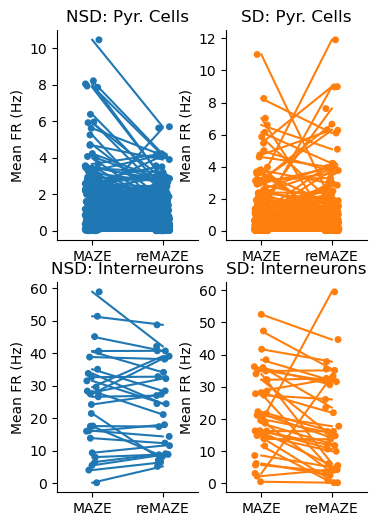

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(4, 6))
for ax, ntype, nname in zip(axs, ["pyr", "inter"], ["Pyr. Cells", "Interneurons"]):
    fr_use = fr_df[fr_df.neuron_type == ntype]
    print(f"{ntype} below")
    print(pg.ttest(fr_use[(fr_use.grp == "SD") & (fr_use.session_type == "MAZE")]["mean_frate"],
         fr_use[(fr_use.grp == "SD") & (fr_use.session_type == "reMAZE")]["mean_frate"],
         paired=True))

    for idg, (gname, a) in enumerate(zip(["NSD", "SD"], ax)):
        pal_use = sns.color_palette()[idg:]
        sns.lineplot(data=fr_df[(fr_df.neuron_type == ntype) & (fr_df.grp == gname)], x="session_type", y="mean_frate",
                     hue="grp", units="nid_unique", estimator=None, legend=False, palette=pal_use, ax=a)
        sns.stripplot(data=fr_df[(fr_df.neuron_type == ntype) & (fr_df.grp == gname)], x="session_type", y="mean_frate", 
                      hue="grp", dodge=True, jitter=True, legend=False, palette=pal_use, ax=a)
        a.set_title(f"{gname}: {nname}")
        a.set_ylabel("Mean FR (Hz)")
        a.set_xlabel("")

sns.despine(fig=fig)

fig.savefig(plot_dir / "fr_stripplot_maze_v_remaze.pdf")

In [17]:
# Create combined colormap, use cmap3[0::2] to plot dark colors and cmap[1::2] to plot same colors but in light / pastel
cmap1 = sns.color_palette(as_cmap=True)
cmap2 = sns.color_palette("pastel", as_cmap=True)
cmap3 = []
for c1, c2 in zip(cmap1, cmap2):
    cmap3.extend([c1, c2])


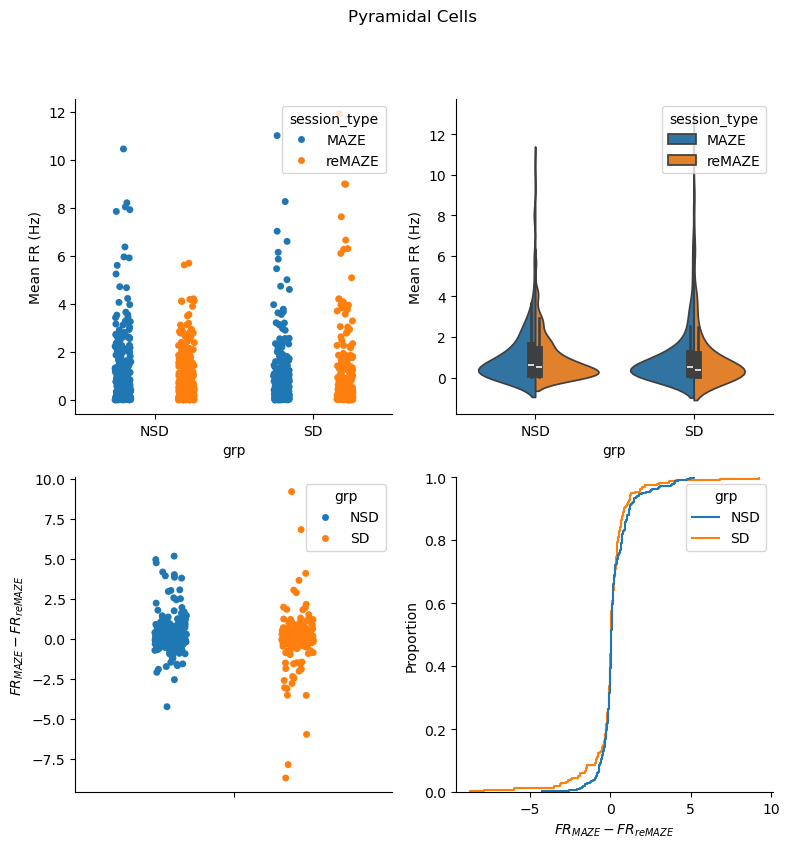

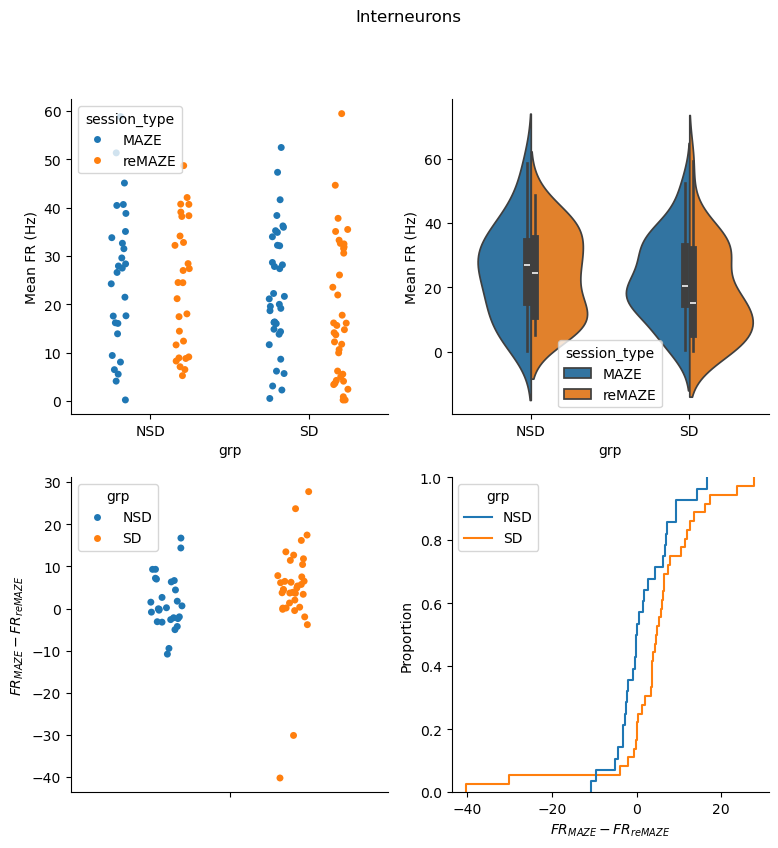

In [18]:
for ntype, nname in zip(["pyr", "inter"], ["Pyramidal Cells", "Interneurons"]):
    fig, axs = plt.subplots(2, 2, figsize=(9, 9))
    fig.suptitle(nname)

    ax = axs[0]
    sns.stripplot(data=fr_df[fr_df.neuron_type == ntype], x="grp", y="mean_frate", hue="session_type", dodge=True, ax=ax[0])
    # sns.lineplot(data=fr_df[fr_df.neuron_type == ntype], x="grp", y="mean_frate", hue="session_type", units="unique_nid", estimator=None, ax=ax[0])
    sns.violinplot(data=fr_df[fr_df.neuron_type == ntype], x="grp", y="mean_frate", hue="session_type", split=True, ax=ax[1])
    [a.set_ylabel("Mean FR (Hz)") for a in ax];
    
    ax2 = axs[1]
    # sns.violinplot(data=fr_df[fr_df.neuron_type == ntype], x="neuron_type", y="delta_frate_maze_remaze", hue="grp", split=True, ax=ax2[0])
    sns.stripplot(data=fr_df[fr_df.neuron_type == ntype], y="delta_frate_maze_remaze", hue="grp", dodge=True, ax=ax2[0])
    ax2[0].set_ylabel(r"$FR_{MAZE} - FR_{reMAZE}$")
    ax2[0].set_xlabel("")
    sns.ecdfplot(data=fr_df[fr_df.neuron_type == ntype], x="delta_frate_maze_remaze", hue="grp", ax=ax2[1])
    ax2[1].set_xlabel(r"$FR_{MAZE} - FR_{reMAZE}$")

    sns.despine(fig=fig)
    fig.savefig(plot_dir / f"FR_{ntype}delta_comprenhensive.pdf")